# CS269Q Tomography Debugger Project
State tomography involves measuring a quantum state repeatedly in the bases given by `itertools.product(['X', 'Y', 'Z], repeat=n_qubits)`. From these measurements, we can reconstruct a density matrix $\rho$. In this project we set out to create a debugging tool to perform state tomography. This project had two parts. The first was constructing a debuggin interface. We decided that our debugger would take the form of a function that could be called on a program and a list of qubits, and would then run tomography algorithms and output a density matrix. The second was choosing an appropriate advanced algorithm to perform state tomography. Since both linear inversion and MLE had already been implemented in the forest benchmarking tomography file (and since Bayesian estimates are apparently "formidable" for quantum states!), we decided to go with matrix completion/compressed sensing methods.

# Relevant Papers & Resources:

[Final Project Instructions](https://cs269q.stanford.edu/hw_and_proj/final_project.pdf)

[Ultra jank state tomography from lecture 6](https://cs269q.stanford.edu/lectures/lecture6.pdf)

[Quantum state tomography via compressed sensing](https://arxiv.org/pdf/0909.3304.pdf)

[NMR Techniques for Quantum Control and Computation](https://arxiv.org/pdf/quant-ph/0404064.pdf)

[Efficient quantum state tomography](https://www.nature.com/articles/ncomms1147.pdf)

[Quantum Tomography via Compressed Sensing: Error Bounds, Sample Complexity, and Efficient Estimators](https://arxiv.org/pdf/1205.2300.pdf)

[Quantum Tomography Wikipedia](https://en.wikipedia.org/wiki/Quantum_tomography#Linear_inversion)

[Forest Benchmarking tomograph.py](https://github.com/rigetti/forest-benchmarking/blob/master/forest/benchmarking/tomography.py)

[PyQuil operator-estimation.py](https://github.com/rigetti/pyquil/blob/master/pyquil/operator_estimation.py)

[Initialization and characterization of open quantum systems](https://uwspace.uwaterloo.ca/bitstream/handle/10012/9557/wood_christopher.pdf?sequence=3&isAllowed=y) (section 3.4)


## TO DO:

<input type="checkbox"> Get basic debugging function working with linear inversion

<input type="checkbox"> Make sure we have the most recent version of forest sdk - seems like files on github are different from the sdk we have!

<input type="checkbox"> Program the compressed sensing algorithm from [Quantum state tomography via compressed sensing](https://arxiv.org/pdf/0909.3304.pdf)

<input type="checkbox"> Decide if we want to program a second tomography algorithm

<input type="checkbox"> Figure out exactly how the debugger will work! Will it just be a function?

<input type="checkbox"> Profile the characteristics of our tomography debugger when faced with noise!

<input type="checkbox"> Change the debugger class to take a qc as an input? Then it can run any program that is given to it on a qvm or a qpu (which is desired functionality!)

<input type="checkbox"> Write final report

In [244]:
import numpy as np
import imp
from pyquil import Program, get_qc
from pyquil.gates import *
from forest.benchmarking.tomography import *
from pyquil.operator_estimation import *
from forest.benchmarking.compilation import basic_compile
from scipy.optimize import minimize
import random

from typing import Union, List

from pyquil.gate_matrices import SWAP, QUANTUM_GATES, STATES
from pyquil.operator_estimation import TensorProductState
from pyquil.paulis import PauliSum, PauliTerm
from pyquil.quilbase import Gate

import cvxpy as cp

## Tomography Debugger Class
This class provides a single method which takes in a program and a list of qubit indices to tomographize and returns the corresponding density matrix.

In [306]:
class TomographyDebugger:
    def __init__(self):
        self.n_shots = 1000
        #i, x, y, z following the paper
        self.paulis = [np.array([[1,0],[0,1]]), np.array([[0,1],[1,0]]), np.array([[0,-1j],[1j,0]]), np.array([[1,0],[0,-1]])]
    
    def advanced_tomography_function(self, results: List[ExperimentResult], qubits: List[int]):
        qubit_num = len(qubits)
        d = 2 ** qubit_num
        pauli_expectation_list = []

        for r in results:
            #Convert the Pauli term into a tensor
            p_tensor = lifted_pauli(r.setting.out_operator, qubits)
            e = r.expectation
            pauli_expectation_list.append((p_tensor, e))
        
        def trace_eval(s):
            tr_sum = 0
            e_sum = 0
            for pauli, e in pauli_expectation_list:
                tr_sum += cp.trace(cp.matmul(pauli, s))
                e_sum += e

            return tr_sum - e_sum == 0
        
        s = cp.Variable((d,d))
        
        obj = cp.Minimize(cp.norm(s))
        constraints = [cp.trace(s) == 1, trace_eval(s)]
        
        # Form and solve problem.
        prob = cp.Problem(obj, constraints)
        prob.solve()
        rho = s.value
        
#         def toVector(s, p):
#             return np.hstack([s.flatten(), p.flatten()])
        
#         def toMatrix(vec):
#             return vec[:d*d].reshape(d,d), vec[d*d:].reshape(d,d)
        
#         #Return value must be 0 for a constraint to be fulfilled

#         def trace_constraint(vec):
#             s, p = toMatrix(vec)
#             return np.trace(s) - 1
        
#         def trace_equality_constraint(vec):
#             s, p = toMatrix(vec)
#             tr_sum = 0
#             for p, e in pauli_expectation_list:
#                 tr_sum += (np.trace(p.dot(s)) - e)
            
#             return tr_sum
        
#         def f(vec):
#             s_flat = vec[:d*d]
#             return sum(s_flat)
        
#         #Start with 0.5 as my guess parameter
#         initial_guess = np.full((2*d*d), 0.25)

#         cons = [{'type':'eq', 'fun': trace_constraint},
#         {'type':'eq', 'fun': trace_equality_constraint}]
        
#         result = minimize(f, initial_guess, method='SLSQP', constraints=cons)
#         print(result)
        
        return rho
        
        #return linear_inv_state_estimate(results=results, qubits=qubits)

    def tomographize(self, program: Program, qubits: List[int]):
        #Generate experiments
        experiment = generate_state_tomography_experiment(program=program, qubits=qubits)

        #Group experiments if possible to minimize QPU runs
        #experiment = group_experiments(experiment)

        #NOTE: Change qvm depending on whether we are simulating qvm
        qc = get_qc('%dq-qvm' % len(qubits))
        qc.compiler.quil_to_native_quil = basic_compile

        results = list(measure_observables(qc=qc, tomo_experiment=experiment, n_shots=self.n_shots))

        rho = self.advanced_tomography_function(results=results, qubits=qubits)
        return np.around(rho, decimals=3)

## Construct a state with a `Program`
We'll construct a two-qubit graph state by Hadamarding all qubits and then applying a controlled-Z operation across edges of our graph. In the two-qubit case, there's only one edge. 

In [307]:
#More complex example!
# qubits = [0, 1, 5]

# program = Program()
# for qubit in qubits:
#     program += H(qubit)
# program += CZ(qubits[0], qubits[1])
# program += X(qubits[1])
# program += RX(-np.pi/2, qubits[2])
# program += RY(-np.pi/2, qubits[0])
# program += X(qubits[2])
# program += CNOT(qubits[2], qubits[0])
# program += CZ(qubits[1], qubits[0])
# program += H(qubits[2])

qubits = [0, 1]

program = Program()
for qubit in qubits:
    program += H(qubit)
# program += CZ(qubits[0], qubits[1])
# program += X(qubits[1])
# program += RX(-np.pi/2, qubits[1])
# program += RY(-np.pi/2, qubits[0])
# program += X(qubits[1])
# program += CNOT(qubits[1], qubits[0])
# program += CZ(qubits[1], qubits[0])
# program += H(qubits[0])

print(program)

H 0
H 1



## Run the tomography debugger and print output

In [308]:
import time

start = time.time()
debugger = TomographyDebugger()
rho = debugger.tomographize(program, qubits)
end = time.time() - start
print("Tomography took %gs" % end)
print("Recovered density matrix:\n")
print(rho)

Tomography took 1.29638s
Recovered density matrix:

[[ 0.493  0.     0.    -0.   ]
 [ 0.     0.007  0.486  0.   ]
 [ 0.     0.486  0.007  0.   ]
 [-0.     0.     0.     0.493]]


## Compare results to true output obtained using wavefunction simulator

In [309]:
from pyquil.api import WavefunctionSimulator
wf_sim = WavefunctionSimulator()
wf = wf_sim.wavefunction(program)
psi = wf.amplitudes

rho_true = np.outer(psi, psi.T.conj())
print(np.around(rho_true, decimals=3))

[[0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j]
 [0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j]
 [0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j]
 [0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j]]


## Visualize using Hinton plots

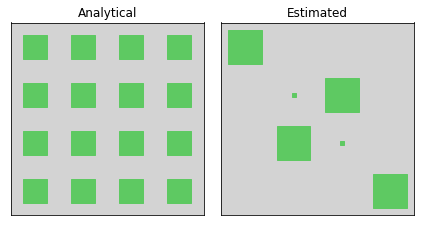

In [310]:
from matplotlib import pyplot as plt
from forest.benchmarking.plotting import hinton
fig, (ax1, ax2) = plt.subplots(1, 2)
hinton(rho_true, ax=ax1)
hinton(rho, ax=ax2)
ax1.set_title('Analytical')
ax2.set_title('Estimated')
fig.tight_layout()

## Calculate matrix norm between true and estimated rho

In [311]:
print(np.linalg.norm(rho - rho_true))

0.986198762927636
